In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import sys
import warnings
import matplotlib.pyplot as plt
import random
warnings.filterwarnings('ignore')

In [6]:
def split_data(data, labels, split):
    from collections import Counter
    distinct_labels = list(Counter(labels).keys())
    n_labels = len(distinct_labels)
    n_split = int(n_labels/split)
    trans = data.T
    trans.columns = labels
    datasets = {}
    datalabels = {}
    for i in range(n_split):
        cond1 = trans.columns.values >= i*split
        cond2 = trans.columns.values < (i+1)*split
        out = trans.iloc[:,cond1&cond2]
        out_label = out.columns.values
        datasets[i] = out.T
        datalabels[i] = out_label
    return (datasets, datalabels)

In [7]:
def generate_transformation_matrix(n_kc,n_orn,n_response,seed):
    R = np.zeros((n_kc, n_orn))
    for i in range(n_kc):
        random.seed(seed+i)
        np.random.seed(seed+i)
        R[i,random.sample(list(range(n_orn)), n_response)] = 1
    return R

def get_KC(p,R,thresh):
    '''
    odor: a vector of ORN responses for a given odor
    w: inhibitory synaptic strength from LN to PN
    R: random linear transformation matrix from PN to KC
    thresh: rectlinear threshold for KC activation
    '''
    KC = np.matmul(R,p)
    KC[KC<=thresh] = 0
    threshold = np.quantile(KC,0.99)
    KC[KC<threshold] = 0
    KC = KC/np.max(KC)
    #KC[KC>0] = 1
    return KC

In [9]:
def train(data, label, lr, n_class, shift):
    from collections import Counter
    weights = np.zeros([n_class,n_kc])#*10.0
    kcs = get_KC(data,R,thresh)
    #kcs = np.array([get_KC(np.array(data.iloc[i,:]),R,thresh) for i in range(data.shape[0])])
    distinct_label = np.sort(list(Counter(label).keys()))
    if len(distinct_label) != n_class:
        raise ValueError('Number of classes to be trained does not match!!!')
    for i in range(n_class):
        sum_kc = np.sum(kcs[np.array(label==distinct_label[i])],axis=0)
        weights[distinct_label[i]-shift] += lr*sum_kc
        #weights[weights<0] = 0
        weights[weights>1] = 1
    return weights

In [10]:
def accu(weights, data, label):
    #kcs = [get_KC(np.array(data.iloc[i,:]),R,thresh) for i in range(data.shape[0])]
    kcs = np.array(kcs)
    result = np.matmul(weights, kcs.T)
    pred = np.argmax(result, axis=0)
    return np.sum(pred==label)/len(label)

In [13]:
train_data = pd.read_csv('../../Research/Lifelong_learning/notebooks/processed_data/cifar100_train_resnet18.csv',header=None)
train_label = pd.read_csv('../../Research/Lifelong_learning/notebooks/processed_data/cifar100_train_label_resnet18.csv',header=None)
train_label = [train_label.values[i][0] for i in range(train_label.shape[0])]
test = pd.read_csv('../../Research/Lifelong_learning/notebooks/processed_data/cifar100_test_resnet18.csv',header=None)
test_label = pd.read_csv('../../Research/Lifelong_learning/notebooks/processed_data/cifar100_test_label_resnet18.csv',header=None)
test_label = [test_label.values[i][0] for i in range(test_label.shape[0])]

In [14]:
train_data = pd.DataFrame(minmax_scale(train_data,axis=1))
test = pd.DataFrame(minmax_scale(test,axis=1))

In [15]:
train_datasets, train_labels = split_data(train_data, train_label, 4)
test_datasets, test_labels = split_data(test, test_label, 4)

In [16]:
n_kc = 20000
n_orn = 512
n_response = 64
seeds = [1,12,21,35,78]
thresh = 0
n_task = 25
lr = 0.2

In [30]:
R = generate_transformation_matrix(n_kc,n_orn,n_response,0)

In [34]:
def get_KC(p,R,thresh):
    '''
    odor: a vector of ORN responses for a given odor
    w: inhibitory synaptic strength from LN to PN
    R: random linear transformation matrix from PN to KC
    thresh: rectlinear threshold for KC activation
    '''
    KC = np.dot(R,p.T)
    KC2 = KC/(np.sum(KC,axis=0)+1e-4)
    KC[KC2<=(1.0/R.shape[0])] = 0
    KC = KC/(np.max(KC,axis=0)+1e-4)
    return KC.T

In [35]:
kcs = get_KC(train_datasets[0],R,thresh)

In [36]:
kcs.shape

(2000, 20000)

In [38]:
len(np.sum(kcs==0,axis=1))

2000

In [39]:
KC = np.dot(R,train_datasets[0].T)
KC2 = KC/(np.sum(KC,axis=0)+1e-4)

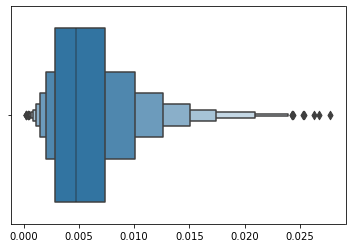

In [49]:
x = np.sum(KC2>1.2/20000,axis=0)/20000
sns.boxenplot(x);

In [ ]:
for seed in seeds:
    R = generate_transformation_matrix(n_kc,n_orn,n_response,seed)
    accuracy = np.zeros([n_task, n_task])
    trained_weights = {}
    for i in range(n_task):
        trained_weights[i] = train(train_datasets[i], train_labels[i], lr, 4, i*4)

        weights_to_test = np.concatenate([trained_weights[j] for j in range(i+1)])

        for j in range(i+1):
            accuracy[i,j] = accu(weights_to_test,test_datasets[j],test_labels[j])

        print('loop '+str(i+1)+' done!')
        
    accuracy = pd.DataFrame(accuracy)
    accuracy.to_csv('./accuracy/FlyModel_cifar100_resnet18_all_result_lr'+str(lr)+'_randseed_'+str(seed)+'.csv',index=False,header=False)